In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from tqdm import tqdm
import librosa
from numba import cuda
import librosa.display
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from sklearn.preprocessing import LabelEncoder
from scipy import signal
from scipy.io import wavfile as wav
from numpy.lib import stride_tricks
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

Using TensorFlow backend.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [4]:
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.config.experimental.set_memory_growth(gpus[0],True)
session = tf.compat.v1.Session(config=configuration)

In [5]:
df = pd.read_csv('TrainZindi.csv')

In [6]:
def build_feats():
    X = []
    Y = []
    for image in tqdm(os.listdir('./spectrograms/')):
        X.append(mpimg.imread('./spectrograms/' + image))
        temp = image.split('.')
#         wavFile = temp[0] + '.wav'
#         print(wavFile)
        classname =df[df.ID == temp[0]].common_name.values
        Y.append(classname[0])
    
    X = np.asarray(X)
    return X,Y

In [7]:
trainX,trainY = build_feats()

100%|█████████████████████████████████████| 1857/1857 [00:03<00:00, 480.21it/s]


In [20]:
trainX[31]

array([[[ 31, 157, 133],
        [ 30, 157, 130],
        [ 31, 160, 129],
        ...,
        [169, 220,  53],
        [177, 221,  46],
        [180, 219,  40]],

       [[ 33, 156, 138],
        [ 32, 155, 135],
        [ 32, 158, 134],
        ...,
        [156, 221,  65],
        [164, 222,  60],
        [166, 221,  55]],

       [[ 30, 147, 139],
        [ 27, 147, 137],
        [ 29, 150, 135],
        ...,
        [119, 206,  75],
        [125, 207,  71],
        [126, 207,  68]],

       ...,

       [[ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83],
        ...,
        [ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83]],

       [[ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83],
        ...,
        [ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83]],

       [[ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83],
        ...,
        [ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83]]

In [9]:
trainY = np.asarray(trainY)
trainY = trainY.flatten()
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
trainY = tf.keras.utils.to_categorical(trainY,num_classes=40)

In [10]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [21]:
train_iterator = datagen.flow(trainX, trainY, batch_size=32)

In [22]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(64,kernel_size=3, activation = 'relu', input_shape=(288,432,3)))
    model.add(Conv2D(32,kernel_size=3, activation = 'relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32,activation='relu'))
    model.add(Dense(40, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
conv_model = get_conv_model()

In [ ]:
cnnScores = conv_model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=30)
# cnnScores = conv_model.fit(features,labels,epochs=30, batch_size=20, shuffle=False, validation_split=0.4)

In [ ]:
#_, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)

In [15]:
cnnScores.history

{'loss': [3.9012020964358016,
  3.6684354729208177,
  3.654707214302059,
  3.643485925116716,
  3.635941943110608,
  3.6314705549290442,
  3.628726181447281,
  3.6271924112327136,
  3.626226490135789,
  3.625922460997689,
  3.6255915944269415,
  3.625324437486015,
  3.625222200466602,
  3.6251605739501067,
  3.62534096963828,
  3.625088283690831,
  3.625179385522648,
  3.625216857425359,
  3.6250745913773117,
  3.6250229106516882,
  3.6249144276304146,
  3.625078727432522,
  3.625000156121159,
  3.6250519269759383,
  3.6251061698346607,
  3.6250943829439377,
  3.625049871851439,
  3.625225393247014,
  3.6251651765713464,
  3.6250095742327844],
 'acc': [0.039849218,
  0.040387724,
  0.044157244,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.053850297,
  0.0538502

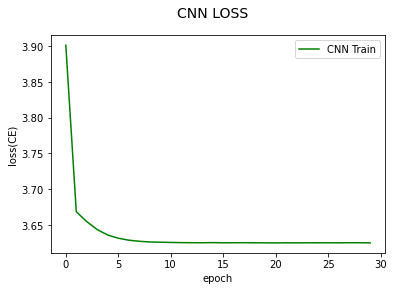

In [16]:
fig = plt.figure()
fig.suptitle('CNN LOSS', fontsize=14)
# pyplot.plot(cnnScores.history['val_loss'],label="CNN Train", color="red")
plt.plot(cnnScores.history['loss'],label="CNN Train", color="green")

plt.xlabel('epoch')
plt.ylabel('loss(CE)')
plt.legend()
plt.show()

In [17]:
cuda.select_device(0)
cuda.close()